In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras import backend as K
from keras import optimizers

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../spectrograms_tugs.pkl', 'rb') as specgram_file:
    patients = pickle.load(specgram_file)

specgrams = [patient['specgram'] for patient in patients]
labels = [patient['label'] for patient in patients]
print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 72


In [4]:
# Split dataset between train and test
train, X_test, y_train, y_test = train_test_split(specgrams, labels, test_size = 0.25, stratify=labels)
print('Training samples: ' + str(len(train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 54
Test samples: 18


In [5]:
# Flip
X_train = []
for specgram in train:
    X_train.append(specgram)
    X_train.append(np.flip(specgram, 0))  # flip rows / y axis
    X_train.append(np.flip(specgram, 1))  # flip columns / x axis
    X_train.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

y_train = [label for label in y_train for _ in range(4)]
print(len(X_train))

216


In [6]:
# Obtain 3 dimensional shape
dim = X_train[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(20, 200, 1)


In [7]:
# Add gaussian noise
noise_factor = 0.05

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

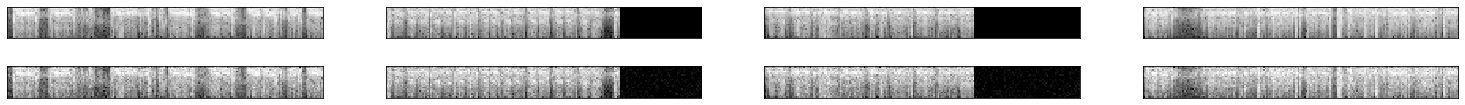

In [8]:
# Visualize original x noisy
n=4
plt.figure(figsize=(26, 2))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_test_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [9]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

In [10]:
X_test[0].shape

(20, 200, 1)

## Autoencoder Model

In [11]:
# input_img = Input(shape=dim)

# # encoder
# code = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
# code = BatchNormalization()(code)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = BatchNormalization()(code)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = BatchNormalization()(code)
# code = MaxPooling2D(pool_size=(5, 5))(code)
# code = Conv2D(2, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = Flatten()(code)
# code = Dense(16, activation='relu')(code)  # bottleneck
# code = Dense(4, activation='relu')(code)  # bottleneck
# bottleneck = Dense(1, activation='relu')(code)  # bottleneck

# autoencoder = Model(input_img, bottleneck)
# autoencoder.summary()

In [12]:
# input_img = Input(shape=dim)

# # encoder
# code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
# code = BatchNormalization()(code)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = BatchNormalization()(code)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(1, kernel_size=(5, 5), padding='same', activation='relu')(code)
# # code = MaxPooling2D(pool_size=(5, 5))(code)
# # code = Conv2D(2, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = Flatten()(code)
# code = Dense(128, activation='relu')(code)  # bottleneck
# code = Dense(32, activation='relu')(code)  # bottleneck
# bottleneck = Dense(1, activation='relu')(code)  # bottleneck

# autoencoder = Model(input_img, bottleneck)
# autoencoder.summary()

In [13]:
input_img = Input(shape=dim)

# encoder
code = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(8, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(2, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = Flatten()(code)
code = Dense(128, activation='relu')(code)
code = Dense(32, activation='relu')(code)
code = Dense(8, activation='relu')(code)
bottleneck = Dense(1, activation='relu')(code)  # bottleneck

autoencoder = Model(input_img, bottleneck)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 200, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 200, 32)       832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 200, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 100, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 100, 8)        6408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 100, 8)        32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 50, 8)          0         
__________

In [14]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=200),
             ModelCheckpoint(filepath='best_model_TUGs_binary.h5', monitor='val_acc', save_best_only=True)]

In [15]:
autoencoder.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.000001), metrics=['accuracy'])
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 1000

# a variável history guarda os dados do processo de treinamento para posteriormente analisarmos
history = autoencoder.fit([X_train], [y_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks, # Early stopping
                    verbose=1,
                    validation_data=([X_test], [y_test]))

Train on 216 samples, validate on 18 samples
Epoch 1/1000
216/216 [==============================] - 2s 8ms/step - loss: 3.5926 - acc: 0.7222 - val_loss: 3.6778 - val_acc: 0.7222
Epoch 2/1000
216/216 [==============================] - 1s 6ms/step - loss: 3.6038 - acc: 0.7269 - val_loss: 3.6773 - val_acc: 0.7222
Epoch 3/1000
216/216 [==============================] - 1s 6ms/step - loss: 3.5822 - acc: 0.7269 - val_loss: 3.6771 - val_acc: 0.7222
Epoch 4/1000
216/216 [==============================] - 1s 6ms/step - loss: 3.4448 - acc: 0.7269 - val_loss: 3.6764 - val_acc: 0.7222
Epoch 5/1000
216/216 [==============================] - 1s 6ms/step - loss: 3.5987 - acc: 0.7222 - val_loss: 3.6755 - val_acc: 0.7222
Epoch 6/1000
216/216 [==============================] - 1s 6ms/step - loss: 3.5763 - acc: 0.7269 - val_loss: 3.6752 - val_acc: 0.7222
Epoch 7/1000
216/216 [==============================] - 1s 5ms/step - loss: 3.5173 - acc: 0.7222 - val_loss: 3.6747 - val_acc: 0.7222
Epoch 8/1000
216/

216/216 [==============================] - 1s 6ms/step - loss: 3.0493 - acc: 0.7176 - val_loss: 3.6840 - val_acc: 0.7222
Epoch 62/1000
216/216 [==============================] - 1s 6ms/step - loss: 3.0516 - acc: 0.7083 - val_loss: 3.6840 - val_acc: 0.7222
Epoch 63/1000
216/216 [==============================] - 1s 6ms/step - loss: 3.0526 - acc: 0.7130 - val_loss: 3.6839 - val_acc: 0.7222
Epoch 64/1000
216/216 [==============================] - 1s 5ms/step - loss: 3.0533 - acc: 0.7176 - val_loss: 3.6838 - val_acc: 0.7222
Epoch 65/1000
216/216 [==============================] - 1s 5ms/step - loss: 3.0506 - acc: 0.7130 - val_loss: 3.6838 - val_acc: 0.7222
Epoch 66/1000
216/216 [==============================] - 1s 5ms/step - loss: 3.0555 - acc: 0.7037 - val_loss: 3.6837 - val_acc: 0.7222
Epoch 67/1000
216/216 [==============================] - 1s 5ms/step - loss: 3.0547 - acc: 0.7176 - val_loss: 3.6837 - val_acc: 0.7222
Epoch 68/1000
216/216 [==============================] - 1s 5ms/step 

216/216 [==============================] - 1s 5ms/step - loss: 2.8580 - acc: 0.7037 - val_loss: 3.6951 - val_acc: 0.7222
Epoch 122/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.8597 - acc: 0.6898 - val_loss: 3.6951 - val_acc: 0.7222
Epoch 123/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.9227 - acc: 0.6991 - val_loss: 3.6951 - val_acc: 0.7222
Epoch 124/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.9054 - acc: 0.7083 - val_loss: 3.6951 - val_acc: 0.7222
Epoch 125/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.9130 - acc: 0.6991 - val_loss: 3.6951 - val_acc: 0.7222
Epoch 126/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.9119 - acc: 0.6991 - val_loss: 3.6950 - val_acc: 0.7222
Epoch 127/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.9782 - acc: 0.6991 - val_loss: 3.6950 - val_acc: 0.7222
Epoch 128/1000
216/216 [==============================] - 1s 5m

216/216 [==============================] - 1s 5ms/step - loss: 2.8433 - acc: 0.6991 - val_loss: 3.6927 - val_acc: 0.7222
Epoch 182/1000
216/216 [==============================] - 1s 6ms/step - loss: 2.8610 - acc: 0.7083 - val_loss: 3.6928 - val_acc: 0.7222
Epoch 183/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.8369 - acc: 0.6991 - val_loss: 3.6928 - val_acc: 0.7222
Epoch 184/1000
216/216 [==============================] - 1s 6ms/step - loss: 2.8496 - acc: 0.7037 - val_loss: 3.6928 - val_acc: 0.7222
Epoch 185/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.8342 - acc: 0.7083 - val_loss: 3.6928 - val_acc: 0.7222
Epoch 186/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.8383 - acc: 0.7083 - val_loss: 3.6927 - val_acc: 0.7222
Epoch 187/1000
216/216 [==============================] - 1s 5ms/step - loss: 2.8415 - acc: 0.6991 - val_loss: 3.6926 - val_acc: 0.7222
Epoch 188/1000
216/216 [==============================] - 1s 5m

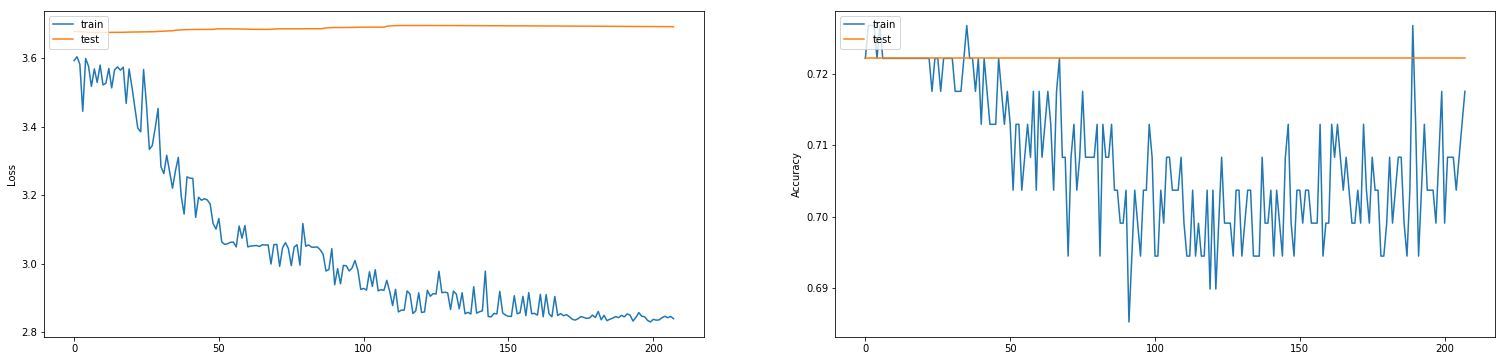

In [16]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# load best model
autoencoder = load_model('best_model_TUGs_binary.h5')

In [18]:
# decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])

start, stop = 0, 12
for i in range(start, stop):
    print('Decoded:', int(decoded_predictions[i]), '\tLabel:', y_test[i])
    
plt.show()

Decoded: 0 	Label: 0
Decoded: 0 	Label: 0
Decoded: 0 	Label: 0
Decoded: 0 	Label: 0
Decoded: 0 	Label: 1
Decoded: 0 	Label: 0
Decoded: 0 	Label: 1
Decoded: 0 	Label: 1
Decoded: 0 	Label: 0
Decoded: 0 	Label: 0
Decoded: 0 	Label: 0
Decoded: 0 	Label: 1
